In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

import openpyxl

In [2]:
# Add funtion to sys.path
os.chdir(pb.__path__[0]+'/..')   
# pb.__path__[0] allow us to location path without concerning different machine
import sys  
sys.path.append(os.path.join(os.getcwd(),'wip\Rio_Code\Fun_P2'))  
from Fun_P2_Union import (GetScan,Run_model_w_dry_out ,Run_model_wo_Dry_out,Cal_new_con_Update,Run_Model_Base_On_Last_Solution,Run_Model_Base_On_Last_Solution_RPT,write_excel_xlsx,)


In [3]:
from pybamm import exp, constants, Parameter
def nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 5.028  # (A/m2)
    alpha = 0.43
    E_r = 2.401e4
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    c_p_max = Parameter("Maximum concentration in positive electrode [mol.m-3]")
    c_e_ref = Parameter("Typical electrolyte concentration [mol.m-3]")
    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_p_max) ** alpha
        * (1 - c_s_surf / c_p_max) ** (1 - alpha))

def nmc_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
        )
        * 10  # correcting factor (see O'Regan et al 2021), mark Ruihe change from 2.7 to 10
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a0 = 11.17
    a1 = -1.553
    a2 = -6.136
    a3 = -9.725
    a4 = 1.85
    b1 = 0.2031
    b2 = 0.5375
    b3 = 0.9144
    b4 = 0.5953
    c0 = -15.11
    c1 = 0.0006091
    c2 = 0.06438
    c3 = 0.0578
    c4 = 0.001356
    d = 2092

    D_ref = (
        10
        ** (
            a0 * sto
            + c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
            + a4 * exp(-((sto - b4) ** 2) / c4)
        )
        * 20  # correcting factor (see O'Regan et al 2021) mark: Ruihe change from 3.0321 
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 12.4  # (A/m2) replaced with value from Schmalstieg et al. (2018), from 2.668 
    alpha = 0.792
    E_r = 4e4
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    c_n_max = Parameter("Maximum concentration in negative electrode [mol.m-3]")
    c_e_ref = Parameter("Typical electrolyte concentration [mol.m-3]")

    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_n_max) ** alpha
        * (1 - c_s_surf / c_n_max) ** (1 - alpha))

def nmc_LGM50_electronic_conductivity_ORegan2021_adjust(T):
    E_r = 3.5e3
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    sigma = 0.8473 * arrhenius

    return sigma


In [ ]:
# ORegan2021:
# Initial concentration in negative electrode [mol.m-3],28866,Chen 2020,
# Initial concentration in positive electrode [mol.m-3],13975,Chen 2020,

str = 'Chen2020_coupled';
ChemistryChen=pb.parameter_sets.+str

In [4]:
V_max = 4.2;        V_min = 2.5;   Temper_RPT = 25; 

#index 
ModelTimer = pb.Timer()
Total_Cycles = 10; save_at_cycles = 1;  

for i in range(0,1):  # Key scan parameters:
    Ratio_excess_i = 1.04;
    cs_Neg_Init_i = 29866 ; Diff_SEI_i = 1.7e-20; # Ruihe old: 28920   default:29866
    R_SEI_i = 2E5;   Bulk_Sol_Con_i = 4541.0;
    D_Li_inSEI_i = 1e-16;    # default: 1e-20 
    c_Li_inte_ref_i = 15;    # default: 15
    Couple_SEI_LiP_i = 1e-6; # default: 1e-6
    k_LiP_i = 1E-10;         # default: 1e-10
    Temper = 25;

Experiment_Long   = pb.Experiment(  
    [(
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ] * Total_Cycles  )  
        
for i in range(0,1):    ######################   update parameter and run first RPT
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   
    ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": 2e-13})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": 1e-13})
    Para_0.update({"Upper voltage cut-off [V]": 4.21})
    Para_0.update({"Lower voltage cut-off [V]": 2.49})
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    Para_0.update({"SEI-plating coupling constant [s-1]": Couple_SEI_LiP_i})     
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})                
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con_i})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})           
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_0 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"interstitial-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    mesh_neg = 50; mesh_pos = 50; 
    var = pb.standard_spatial_vars  
    var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: mesh_neg,  var.r_p: mesh_pos,  }
    Sim_0    = pb.Simulation(
        Model_0,        experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
        ) #mode="safe"
    Sol_0    = Sim_0.solve(save_at_cycles = save_at_cycles)

In [ ]:
x_n = pb.standard_spatial_vars.x_n

In [5]:
D_Li_inSEI_i = 1e-16;
for i in range(0,1):    ######################   update parameter and run first RPT
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   
    ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": 2e-13})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": 1e-13})
    Para_0.update({"Upper voltage cut-off [V]": 4.21})
    Para_0.update({"Lower voltage cut-off [V]": 2.49})
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    Para_0.update({"SEI-plating coupling constant [s-1]": Couple_SEI_LiP_i})     
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})                
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con_i})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})           
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_0 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    mesh_neg = 100; mesh_pos = 100; 
    var = pb.standard_spatial_vars  
    var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: mesh_neg,  var.r_p: mesh_pos,  }
    Sim_1    = pb.Simulation(
        Model_0,        experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
        ) #mode="safe"
    Sol_1    = Sim_1.solve(save_at_cycles = save_at_cycles)

In [ ]:
# get maximum and mimunm solid/liquid concentration 
time_all = Sol_0["Time [h]"].entries; 
x_n = Sol_0.cycles[0].steps[0]["x_n [m]"].entries[:,-1]; 
r_n = Sol_0.cycles[0].steps[0]["r_n [m]"].entries[:,-1]; 
x = Sol_0.cycles[0].steps[0]["x [m]"].entries[:,-1];  
c_NegMaxSurf = Sol_0[
    "Maximum negative particle surface concentration"].entries;  
c_PosMaxSurf = Sol_0[
    "Maximum positive particle surface concentration"].entries; 
SOC_Neg = Sol_0["Negative electrode SOC"].entries; 
SOC_Pos = Sol_0["Positive electrode SOC"].entries;     

In [ ]:
# Plot SOC change
Num_subplot = 2; fs=19
fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
axs[0].plot(time_all,c_NegMaxSurf, '-', label="Max Surf" ) # first cycle
axs[0].plot(time_all,SOC_Neg, '-',label="avg SOC" ) # last cycle
axs[1].plot(time_all,c_PosMaxSurf, '-',label="Max Surf" ) # last cycle
axs[1].plot(time_all,SOC_Pos, '-',label="avg SOC" ) # last cycle
for i in range(0,Num_subplot):    
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'Times New Roman','size':fs})
    axs[i].set_ylabel("SOC",   fontdict={'family':'Times New Roman','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)  

axs[0].set_title(f"Neg", fontdict={'family':'Times New Roman','size':fs+1})
axs[1].set_title(f"Pos", fontdict={'family':'Times New Roman','size':fs+1})

In [16]:
Model_0.variables.search('Electrolyte concentration')

Electrolyte concentration
Electrolyte concentration [Molar]
Electrolyte concentration [mol.m-3]
Negative electrolyte concentration
Negative electrolyte concentration [Molar]
Negative electrolyte concentration [mol.m-3]
Positive electrolyte concentration
Positive electrolyte concentration [Molar]
Positive electrolyte concentration [mol.m-3]
Separator electrolyte concentration
Separator electrolyte concentration [Molar]
Separator electrolyte concentration [mol.m-3]
X-averaged electrolyte concentration
X-averaged electrolyte concentration [Molar]
X-averaged electrolyte concentration [mol.m-3]
X-averaged negative electrolyte concentration
X-averaged negative electrolyte concentration [mol.m-3]
X-averaged positive electrolyte concentration
X-averaged positive electrolyte concentration [mol.m-3]
X-averaged separator electrolyte concentration
X-averaged separator electrolyte concentration [mol.m-3]


In [ ]:
print(len(r_n))
print(len(x_n))
print(len(x))

In [ ]:
label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Negative electrode SOC",
                "Positive electrode SOC",
                "Electrolyte potential [V]",
                "Maximum negative particle surface concentration",
                "Maximum positive particle surface concentration",
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
(0.05*3600/96485)  * 9.8e-5 * 1e6   # covert LLI to SEI (Ah)-0.05 into SEI volume (mL) 
#Para_0["Inner SEI partial molar volume [m3.mol-1]"]

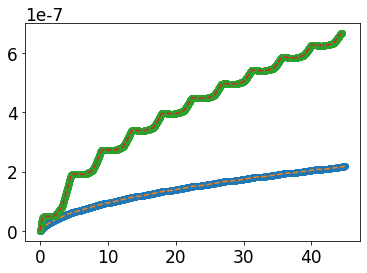

In [14]:
# check SEI growth and porosity decrease here:
# X-average porosity vs LLI TO SEI in mol plus LiP
L_p   =Para_0["Positive electrode thickness [m]"]
L_n   =Para_0["Negative electrode thickness [m]"]
L_s   =Para_0["Separator thickness [m]"]
L_y   =Para_0["Electrode width [m]"]   
L_z   =Para_0["Electrode height [m]"]
PoreVolNeg = Sol_0["X-averaged negative electrode porosity"].entries*L_n*L_y*L_z;
PoreVolSep = Sol_0["X-averaged separator porosity"].entries*L_s*L_y*L_z;
PoreVolPos = Sol_0["X-averaged positive electrode porosity"].entries*L_p*L_y*L_z;

LLINegSEI = (
    Sol_0["Loss of lithium to negative electrode SEI [mol]"].entries
    - 
    Sol_0["Loss of lithium to negative electrode SEI [mol]"].entries[0]
    )
LLINegLiP = (
    Sol_0["Loss of lithium to negative electrode lithium plating [mol]"].entries
    - 
    Sol_0["Loss of lithium to negative electrode lithium plating [mol]"].entries[0]
)
VmolSEI   = Para_0["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
VmolLiP   = Para_0["Lithium metal partial molar volume [m3.mol-1]"] # 1.3e-05
Vol_SEILiP_increase = 1.0*(LLINegSEI * VmolSEI + LLINegLiP * VmolLiP) 

PoreVolNeg_dec = PoreVolNeg[0] - PoreVolNeg;
# 
PoreVolNeg_1 = Sol_1["X-averaged negative electrode porosity"].entries*L_n*L_y*L_z;
PoreVolSep_1 = Sol_1["X-averaged separator porosity"].entries*L_s*L_y*L_z;
PoreVolPos_1 = Sol_1["X-averaged positive electrode porosity"].entries*L_p*L_y*L_z;

LLINegSEI_1 = (
    Sol_1["Loss of lithium to negative electrode SEI [mol]"].entries
    - 
    Sol_1["Loss of lithium to negative electrode SEI [mol]"].entries[0]
    )
LLINegLiP_1 = (
    Sol_1["Loss of lithium to negative electrode lithium plating [mol]"].entries
    - 
    Sol_1["Loss of lithium to negative electrode lithium plating [mol]"].entries[0]
)
VmolSEI   = Para_0["Outer SEI partial molar volume [m3.mol-1]"] # 9.8e-5,
VmolLiP   = Para_0["Lithium metal partial molar volume [m3.mol-1]"] # 1.3e-05
Vol_SEILiP_increase_1 = 1.0*(LLINegSEI_1 * VmolSEI + LLINegLiP_1 * VmolLiP) 

PoreVolNeg_dec_1 = PoreVolNeg_1[0] - PoreVolNeg_1;

Time_1 =Sol_1["Time [h]"].entries

plt.plot(Time_1,Vol_SEILiP_increase_1,'-o')
plt.plot(Time_1,PoreVolNeg_dec_1,'--')

Time =Sol_0["Time [h]"].entries

plt.plot(Time,Vol_SEILiP_increase,'-o')
plt.plot(Time,PoreVolNeg_dec,'--')

In [15]:
(9.8e-5 + 1.3e-05) / 6.667e-5

1.664916754162292

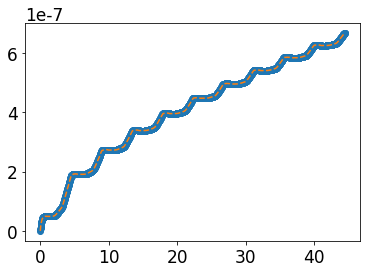

In [11]:
print(Sol_0["Loss of lithium to negative electrode SEI [mol]"].entries[0])
print(Sol_0["Loss of lithium to negative electrode lithium plating [mol]"].entries[0])

-1.9457321609044982e-20
0.0


In [ ]:
label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
output_variables3 = [
                "Loss of capacity to negative electrode lithium plating [A.h]",
                "Loss of capacity to positive electrode dead lithium plating [A.h]",
                "Loss of capacity to negative electrode SEI [A.h]",
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Negative electrode SOC",
                "Positive electrode SOC",
                "Electrolyte potential [V]",
                "Negative particle surface concentration [mol.m-3]",
                "Terminal voltage [V]",
                "SEI interfacial current density [A.m-2]",
                "Porosity"
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16" ]
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Loss of capacity to negative electrode SEI [A.h]",
                "Loss of capacity to negative electrode lithium plating [A.h]",         
                "Negative electrode interfacial current density [A.m-2]",
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:

Cap  =Sol_0["Discharge capacity [A.h]"].entries

Time =Sol_0["Time [h]"].entries
NegSoc=Sol_0["Negative electrode SOC"].entries
PosSoc=Sol_0["Positive electrode SOC"].entries


Num_subplot = 2; fs=19
fig, axs = plt.subplots(1,2, figsize=(14,5),tight_layout=True)
axs[0].plot(Time,Cap, '-', label="Cap" ) # first cycle
axs[1].plot(Time,NegSoc, '-',label="Neg" ) # last cycle
axs[1].plot(Time,PosSoc, '-',label="Pos" ) # last cycle
axs[0].set_ylabel("Discharge cap [A.h]",   fontdict={'family':'Times New Roman','size':fs})
axs[1].set_ylabel("SOC",   fontdict={'family':'Times New Roman','size':fs})
for i in range(0,Num_subplot):    
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'Times New Roman','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)  

axs[0].set_title(f"Discharge capacity", fontdict={'family':'Times New Roman','size':fs+1})
axs[1].set_title(f"Electrode SOC", fontdict={'family':'Times New Roman','size':fs+1})

In [ ]:

plt.plot(Time,NegSoc)
plt.plot(Time,PosSoc)

In [ ]:
Experiment_Long_1   = pb.Experiment(  
    [(
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ] * 6  )  
Model_1= Model_0.set_initial_conditions_from(Sol_0, inplace=False)
Sim_1    = pb.Simulation(
    Model_1,        experiment = Experiment_Long_1,
    parameter_values = Para_0,
    solver = pb.CasadiSolver(),
    var_pts=var_pts,
    ) #mode="safe"
Sol_1    = Sim_1.solve()

In [ ]:
V_max = 4.2;        V_min = 2.5;   Temper_RPT = 25; 

#index 
ModelTimer = pb.Timer()
Total_Cycles = 16; save_at_cycles = 1;  

# Key scan parameters:
Ratio_excess_i = 1.04;
cs_Neg_Init_i = 28866 ; Diff_SEI_i = 1.7e-20; # Ruihe old: 28920  
R_SEI_i = 2E5;   Bulk_Sol_Con_i = 4541.0;
D_Li_inSEI_i = 3e-21;    # default: 1e-20 
c_Li_inte_ref_i = 15;    # default: 15
Couple_SEI_LiP_i = 1e-6; # default: 1e-6
k_LiP_i = 1E-10;         # default: 1e-10
Temper = 25;

Experiment_Long   = pb.Experiment(  
    [(
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ] * Total_Cycles  )  
        
for i in range(0,1):    ######################   update parameter and run first RPT
    ChemistryChen=pb.parameter_sets.Chen2020_coupled   
    ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": graphite_LGM50_diffusivity_ORegan2021_adjust})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": nmc_LGM50_diffusivity_ORegan2021_adjust})
    Para_0.update({"Negative electrode exchange-current density [A.m-2]": 
        graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust})
    Para_0.update({"Positive electrode exchange-current density [A.m-2]": 
        nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust})
    Para_0.update({"Positive electrode conductivity [S.m-1]": 
        0.8473})
    Para_0.update({"Negative electrode Bruggeman coefficient (electrode)": 
        0.0})
    #Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init_i })
    #Para_0.update({'Initial concentration in positive electrode [mol.m-3]':13975 })  
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    Para_0.update({'Initial electrolyte excessive amount ratio':Ratio_excess_i})   # 
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    Para_0.update({"SEI-plating coupling constant [s-1]": Couple_SEI_LiP_i})     
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})                
    Para_0.update({'Current solvent concentration in the reservoir [mol.m-3]':Bulk_Sol_Con_i})     
    Para_0.update({'Current electrolyte concentration in the reservoir [mol.m-3]':1000.0})           
    Para_0.update({'Ratio of Li-ion concentration change in electrolyte consider solvent consumption':  
                    1.0 })
    Model_11 = pb.lithium_ion.DFN(     
    options={
        "particle": "Fickian diffusion",          
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",         
        "lithium plating":"partially reversible"     } ) #
    ModelTimer = pb.Timer()
    mesh_neg = 50; mesh_pos = 50; 
    var = pb.standard_spatial_vars  
    var_pts = {var.x_n: 20,  var.x_s: 10,  var.x_p: 20,  var.r_n: mesh_neg,  var.r_p: mesh_pos,  }
    Sim_11    = pb.Simulation(
        Model_11,        experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pb.CasadiSolver(),
        var_pts=var_pts,
        ) #mode="safe"
    Sol_11    = Sim_11.solve()

In [ ]:
Experiment_Long_6   = pb.Experiment(  
    [(
        f"Discharge at 1 C for 3928 s", ), ] * 1  ) 
Model_6= Model_0.set_initial_conditions_from(Sol_0, inplace=False)
Sim_6 = pb.Simulation(
        Model_6,
        experiment = Experiment_Long_6, 
        parameter_values=Para_0, 
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
    )
Sol_6 = Sim_6.solve() 

In [ ]:
Para_0.update({"Negative electrode Bruggeman coefficient (electrode)": 
        0.0})
def nmc_LGM50_diffusivity_ORegan2021_adjust_2(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
        )
        * 10  # correcting factor (see O'Regan et al 2021)
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius
    
Para_0.update({"Positive electrode diffusivity [m2.s-1]": 
        nmc_LGM50_diffusivity_ORegan2021_adjust_2})

Experiment_Long_7   = pb.Experiment(  
    [(
        f"Discharge at 1 C for 3929 s", ), ] * 1  ) 
Model_7= Model_0.set_initial_conditions_from(Sol_0, inplace=False)
Sim_7 = pb.Simulation(
        Model_7,
        experiment = Experiment_Long_7, 
        parameter_values=Para_0, 
        solver = pb.CasadiSolver(),
        #var_pts=var_pts,
    )
Sol_7 = Sim_7.solve() 

In [ ]:
# Now we have: Sol_6 (dis 3928) Sol_5 (dis 3900) Sol_4 (dis 3928) Sol_0 (normal 5 cycles)